<a href="https://colab.research.google.com/github/inbalv/tictactoe/blob/master/IS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,DecisionTreeClassifier

In [ ]:
def create_spark_session(app_name='SparkApplication',master='local[*]'):
    spark_session = SparkSession.builder \
        .appName(app_name) \
        .master(master) \
        .getOrCreate()

    spark_session.sparkContext.setLogLevel('WARN')
    return spark_session

def set_spark_submit_args():
    args,jars,packages = [],[],[]
    args.append('--conf spark.driver.maxResultSize=16g')
    args.append('--driver-memory 16g')
    args.append('--executor-memory 16g')

    args.append('pyspark-shell')
    pyspark_submit_args = ' '.join(args)
    print ('PYSPARK_SUBMIT_ARGS = ' + pyspark_submit_args)
    os.environ['PYSPARK_SUBMIT_ARGS'] = pyspark_submit_args


#set_spark_submit_args()
spark = create_spark_session()

In [ ]:
#read,join and sample from data
x='C:/IS1'
df1 = spark.read.parquet(x)
x='C:/IS2'
df2 = spark.read.parquet(x)
print(df1.printSchema)
print(df2.printSchema)

df = df1.join(df2, on=['id']).drop(df2.id)
#sc = df.sql_ctx.sparkSession.sparkContext
df=df.sample(False,0.05,seed=42)
df.cache()

<bound method DataFrame.printSchema of DataFrame[id: string, feature_1: string, feature_2: string, feature_3: string, feature_4: string, feature_5: string, feature_6: string, feature_7: string, feature_8: string, feature_9: string, label: string]>
<bound method DataFrame.printSchema of DataFrame[id: string, feature_10: string, feature_11: string, feature_12: string, feature_13: string, feature_14: string, feature_15: string, feature_16: string, feature_17: string, feature_18: string, feature_19: string, feature_20: string, feature_21: string, feature_23: string]>


DataFrame[id: string, feature_1: string, feature_2: string, feature_3: string, feature_4: string, feature_5: string, feature_6: string, feature_7: string, feature_8: string, feature_9: string, label: string, feature_10: string, feature_11: string, feature_12: string, feature_13: string, feature_14: string, feature_15: string, feature_16: string, feature_17: string, feature_18: string, feature_19: string, feature_20: string, feature_21: string, feature_23: string]

In [ ]:
#check for distinct values (very slow) :
'''
from pyspark.sql import functions as F, DataFrame
y=df1.columns
print(y)
for col in y:
    if (col != 'id') and (col!='feature_1'):
        print(df1.groupby(df1[col]).count().show(1000))


'''
'''
#conclusion :

feature_2-num
feature_3-num
feature_4-?
feature_5-cat more than 100 values
feature_6-cat more than 100 values
feature_7- cat ~ 20 values
feature_8-cat more than 100 values
feature_9-cat 3 values
feature_10-cat 7 values
feature_11-cat 7 values
feature_12-? has -1,  more than 100 values
feature_13-cat  more than 100 values
feature_14-cat  more than 100 values
feature_15-cat  more than 50
feature_16-cat  5 values
feature_17-cat  cat more than 100 values
feature_18-cat  cat 4 values
feature_19-cat  cat 8 values
feature_20-cat  ~20 values
feature_21-cat  more than 100 values
feature_23-cat  9 values
'''


'\n#conclusion :\n  \nfeature_2-num\nfeature_3-num\nfeature_4-?\nfeature_5-cat more than 100 values\nfeature_6-cat more than 100 values\nfeature_7- cat ~ 20 values\nfeature_8-cat more than 100 values\nfeature_9-cat 3 values\nfeature_10-cat 7 values\nfeature_11-cat 7 values\nfeature_12-? has -1,  more than 100 values\nfeature_13-cat  more than 100 values\nfeature_14-cat  more than 100 values\nfeature_15-cat  more than 50\nfeature_16-cat  5 values\nfeature_17-cat  cat more than 100 values\nfeature_18-cat  cat 4 values\nfeature_19-cat  cat 8 values\nfeature_20-cat  ~20 values\nfeature_21-cat  more than 100 values\nfeature_23-cat  9 values\n'

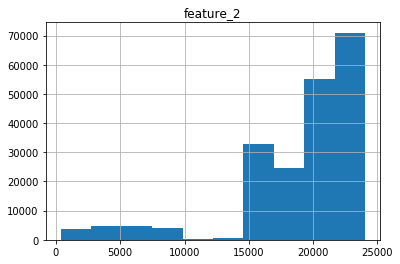

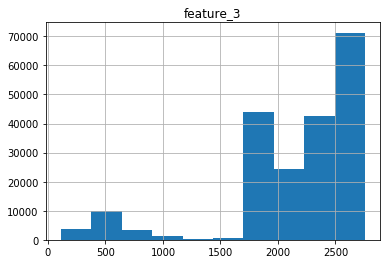

In [ ]:
#cast numeric columns and plot it
numeric_columns=['feature_2','feature_3']

for col in numeric_columns:
    df = df.withColumn(col,df[col].cast(DoubleType()))

#plot numeric columns hists
df.select(numeric_columns).describe().toPandas().transpose()

df_pd = df.toPandas()
%matplotlib inline
import matplotlib.pyplot as plt

for col in numeric_columns:
    df_pd.hist(column=col)

In [ ]:
#check for imbalance in all df
df= df.withColumn('label',df['label'].cast(DoubleType()))
numPositive = df.filter(F.col("label") == 1).count()
datasetSize = df.count()
numNegative = datasetSize-numPositive
print(' Imbalance data: \n ','#positive: ',numPositive,'#negative:',numNegative,'#total',datasetSize,'#ratio',numPositive/datasetSize)

#split train and test (unfortunatly did not have time to train for validation df)

train, test = df.randomSplit([0.7, 0.3], seed = 2018)
train.cache()
test.cache()

#Imbalanced data -underSampling for class zero  on train
trainPositive = train.filter(F.col("label") == 1)
trainNegative = train.filter(F.col("label") == 0)
trainNegative=trainNegative.sample(False,0.6,seed=42)
train=trainNegative.union(trainPositive)

numPositive = train.filter(F.col("label") == 1).count()
datasetSize = train.count()
numNegative = datasetSize-numPositive
print(' Imbalance data after undersampling: \n ','#positive: ',numPositive,'#negative:',numNegative,'#total',datasetSize,'#ratio',numPositive/datasetSize)







 Imbalance data: 
  #positive:  34258 #negative: 167398 #total 201656 #ratio 0.16988336573174118
 Imbalance data after undersampling: 
  #positive:  23980 #negative: 70228 #total 94208 #ratio 0.25454313858695654


In [ ]:
#numeric transformations

def getStandardize(df, numeric_columns):
    convs = []
    for col in numeric_columns:
        std, mean = df.agg(F.stddev(col), F.avg(col)).take(1)[0][:]
        df.withColumn(col, (df[col] - mean) / std)

    return df


#replace missing numeric values with median
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=numeric_columns, outputCols=numeric_columns,strategy ='median')
model = imputer.fit(train)

train=model.transform(train)
test=model.transform(test)

#standardize- mean+std (prob not the best choice here since the histogram shows 2 groups)
train=getStandardize(train, numeric_columns)
test=getStandardize(test, numeric_columns)





In [ ]:
#categorical transformations
categorical_columns=['feature_7','feature_9','feature_10','feature_11','feature_15','feature_16','feature_18','feature_19','feature_20','feature_23']

for col in categorical_columns:
    train = train.na.fill({col: 'unknown'})
    test=test.na.fill({col: 'unknown'})

'''
def removeNonFrequent(train,test, minRequiredSymbolAppearances, categorical_columns, replacementSymbol):
    #####decided not to present the code here
    return train,test


train,test=removeNonFrequent(train,test, 50,categorical_hashing_columns, 'nonFerq')
#feature hashing for categorical_columns_manyValues:didn't have time to develop it
#(featureHasher avialible only on scala\java for my pyspark version )
'''

" \ndef removeNonFrequent(train,test, minRequiredSymbolAppearances, categorical_columns, replacementSymbol):\n    #####decided not to present the code here    \n    return train,test \n\n\ntrain,test=removeNonFrequent(train,test, 50,categorical_hashing_columns, 'nonFerq')\n#feature hashing for categorical_columns_manyValues:didn't have time to develop it \n#(featureHasher avialible only on scala\\java for my pyspark version )\n"

In [ ]:
def constructOneHotEncodingPipeline(categorical_columns, numeric_columns, **kwargs):
    indexers = [
        StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("keep")
        for c in categorical_columns
    ]

    encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(),
                              outputCol="{0}_encoded".format(indexer.getOutputCol()))
                for indexer in indexers
                ]
    #hashers=[FeatureHasher(inputCol=c, outputCol="{0}_hashed".format(c)) for c in categorical_hashing_columns]



    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]+numeric_columns, **kwargs)

    stages = indexers + encoders + [assembler]
    return stages

ohe = constructOneHotEncodingPipeline(categorical_columns, numeric_columns, outputCol='final_features')

stages = ohe
pipelineModelOHE = Pipeline(stages=stages).fit(train)
train=pipelineModelOHE.transform(train)
test=pipelineModelOHE.transform(test)

In [ ]:

def constructLR(**kwargs):
    lrModel = LogisticRegression(**kwargs)
    return lrModel

def constructGBT(**kwargs):
    gbtModel =  GBTClassifier(**kwargs)
    return gbtModel

def constructRF(**kwargs):
    rfModel =  RandomForestClassifier(**kwargs)
    return rfModel

def constructTree(**kwargs):
    treeModel =  DecisionTreeClassifier(**kwargs)
    return treeModel

--- # Iterations till convergence:  154
--- # Number of features  :  155
--- # coefficients  :  {}
--- # intercept:  -1.0574493382159404


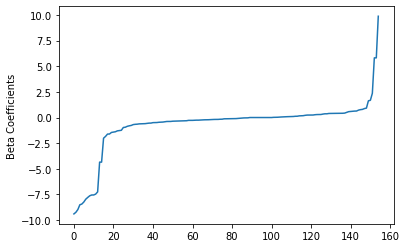

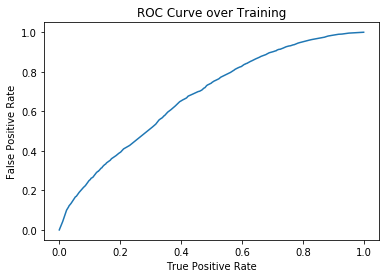

Training set areaUnderROC: 0.6754763960046638


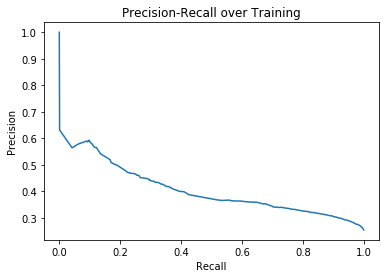

In [ ]:


#logistic regression
lr = constructLR(featuresCol='final_features', labelCol='label',
                     maxIter=1000, regParam=0.00001, tol=1e-06,
                     standardization=True)
stages = [lr]
pipelineModelLR = Pipeline(stages=stages).fit(train)


#optional plots for LR
''''''
lablesCts = []
for index, stage in enumerate(pipelineModelOHE.stages):
    if type(stage) == type(pipelineModelOHE.stages[0]):
        for s in stage.labels:
            x = str(categorical_columns[index] + '_' + s)
            lablesCts.append(x)


coeff = list(pipelineModelLR.stages[-1].coefficients)
coeffDic = {}
for index, value in enumerate(lablesCts):
    coeffDic.update({value: coeff[index]})

print('--- # Iterations till convergence: ', pipelineModelLR.stages[-1].summary.totalIterations)
print('--- # Number of features  : ',pipelineModelLR.stages[-1].coefficientMatrix.numCols)
print('--- # coefficients  : ',coeffDic)
print('--- # intercept: ',pipelineModelLR.stages[-1].intercept)


import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(pipelineModelLR.stages[-1].coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

trainingSummary = pipelineModelLR.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve over Training')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall over Training')
plt.show()

predictionsLR= pipelineModelLR.transform(test)

In [ ]:
#Tree Classifier

tree = constructTree(labelCol='label', featuresCol='final_features', maxDepth=7)
stages = [tree]
pipelineModeltree = Pipeline(stages=stages).fit(train)

predictionstree= pipelineModeltree.transform(test)



In [ ]:
#Random Forest

rf = constructRF(labelCol='label', featuresCol='final_features', numTrees=3)
stages = [rf]
pipelineModelRF = Pipeline(stages=stages).fit(train)

predictionsRF = pipelineModelRF.transform(test)







In [ ]:
#evaluation
import pyspark.sql.functions as F
from pyspark.sql.functions import when, log
from pyspark.ml.evaluation import BinaryClassificationEvaluator


def firstElement(col):
        return F.udf(lambda v: float(v[1]), FloatType())(col)

def AUC(predictions):
    evaluator = BinaryClassificationEvaluator().setLabelCol("label").\
        setRawPredictionCol("probability").setMetricName("areaUnderROC")
    auc = evaluator.evaluate(predictions)
    return auc

def logLossCalculator(predictions, probabilityField):
    predictions = (predictions.withColumn('logloss', -F.col('label')*F.log(F.col( probabilityField)) - (1.-F.col('label'))*F.log(1.-F.col( probabilityField))))
    loglossTotal =predictions.agg(F.mean('logloss').alias('ll')).collect()[0]['ll']
    return loglossTotal

def AUPR(predictions):
    evaluator = BinaryClassificationEvaluator().setLabelCol("label").\
        setRawPredictionCol("probability").setMetricName("areaUnderPR")
    aupr = evaluator.evaluate(predictions)
    return aupr


def loglossAucReview(predictions, predictionProbabilityField,modelType='Example'):
        loglossModel = logLossCalculator(predictions, predictionProbabilityField)
        aucModel = AUC(predictions)
        auprModel=AUPR(predictions)
        print('ModelType:\t\t',modelType)
        print('loglossModel:\t\t', loglossModel)
        print('aucModel:\t\t', aucModel)
        print('auprModel:\t\t',  auprModel)
        print('\n')

        return loglossModel, aucModel, auprModel


predictionstree = predictionstree.withColumn('probability1', firstElement('probability') )
predictionProbabilityFieldTree='probability1'
loglossAucReview(predictionstree, predictionProbabilityFieldTree,modelType='Decision tree')

predictionsRF = predictionsRF.withColumn('probability1', firstElement('probability') )
predictionProbabilityFieldRF='probability1'
loglossAucReview(predictionsRF, predictionProbabilityFieldRF,modelType='Random Forest')


predictionsLR = predictionsLR.withColumn('probability1', firstElement('probability') )
predictionProbabilityFieldLR='probability1'
evaluations=loglossAucReview(predictionsLR, predictionProbabilityFieldLR,modelType='Logistic Regression')




ModelType:	 Decision tree
loglossModel:	 0.4463673653740204
aucModel:		 0.6595469417813258
auprModel:		 0.30551032985762994


ModelType:	 Random Forest
loglossModel:	 0.4505925867101202
aucModel:		 0.6623307892050623
auprModel:		 0.301131942230702


ModelType:	 Logistic Regression
loglossModel:	 0.44559248691910247
aucModel:		 0.6717697013338538
auprModel:		 0.29082100691075985




(0.44559248691910247, 0.6717697013338538, 0.29082100691075985)